In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from nb21 import cumulative_elast_curve_ci, elast, cumulative_gain_ci

One downside of evaluation like the ones above is that they all deppend on having random data. That is because we need to trust our elasticity estimation, which is very complicated thing to do in the absense of random data. For all intend and purposes, I would only recomend those evaluations if you have some random data. However, this is not always possible. When it is not, there is still a way out, but I would still aproach it very critically. 

## Non Random Data

Cummulative elasticity and the Qini curves need to estimate the average elasticity of a sample in order to work properly. Remember that the average elasticity is the end point of the curves we've seen above. Is the average elasticity is off, the whole thing blows up. To give an example, let's say that, on our icecream example, because we used to rise prices during the weekends, it looked like the higher the price, the higher the sales ammount (wihch is obvious nonsense). When we plot such a Qini curve, it would look like the average price elasticity is positive and we would look for models that can segment the sample in a way to make it even more positive. Of course, this doesn't make any sence, since economic theory tells us that sales should go down as we increase price.

To correct that, we need to somehow debias our data. To show you how to do that, consider that we don't have access to the random data anymore. Now, we have to split our non random data into a training and a validation set.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv")

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

Next, we have to make it so that the evaluation or test set is not biased.

## Debiasing the Test

If we show the correlation on the test set, we can see that price is positively correlated with sales, meaning that sales should go up as we increase prices. This is obviously nonsense

In [4]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,0.005421,-0.003284,-0.005308,0.371862
weekday,0.005421,1.000000,-0.013390,-0.015464,0.001129
cost,-0.003284,-0.013390,1.000000,0.389408,-0.024582
price,-0.005308,-0.015464,0.389408,1.000000,0.072992
sales,0.371862,0.001129,-0.024582,0.072992,1.000000


If we plot our data, we can see why this is happening. Weekends (Saturday and Sunday) have higer price but also higher sales. We can see that this is the case because the weekend cloud of points seems to be to the right upper part of the plot. This idicates the same sort of bias we where talking about earlier.

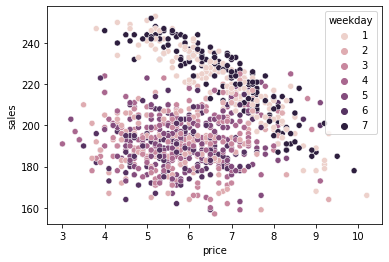

In [5]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

To debias this dataset we will need to models. The first model, let's call it \\(M_t(X)\\), predicts the treatment (price, in our case) using the confounder. Here, we will use a regression model for \\(M_t(X)\\).

In [6]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

Once we have this model, we will construct the residuals

$$
\hat{t}_i = t_i - M_t(X_i)
$$

You can think of this residual as a version of the treatment that is unbiased or, better yet, that is inpossible to predict from the confounders \\(X\\). Since the confounders where already used to predict \\(t\\), the residual is by definition, unpredictable with \\(X\\). Another way of saying this is that the biase have been explained away by the model \\(M_t(X_i)\\), prudicing \\(\hat{t}_i\\) wich is as good as randomm

Of course this only works if we have in \\(X\\) all the confounders that causes both \\(T\\) and \\(Y\\). Just for the sake of ilustration, here is what happens to the data when we debiased \\(t\\). 

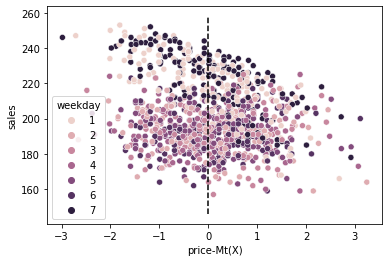

In [7]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles='--', color="black");

We can see that the weekends are no longer to the upper right corned. They got pushed to the center. As we can see, price (the treatment) doesn't differentiate in any sistematic way according to the weekday.

This alone is suficient to debias the dataset. But we can still do one other thing to make the debiased sample better. Namely, we can also contruct residuals for the outcome.


$$
\hat{y}_i = y_i - M_y(X_i)
$$

This doesn't make the set less biased, but it makes it easier to estimate the elasticity. Once again, you can think about \\(\hat{y}_i\\) as a version of \\(y_i\\) that is unpredictable from \\(X\\) or that had all its variances due to \\(X\\) explained away. If that is the case, the only thing left to explain \\(\hat{y}_i\\) is something we didn't used to construct it (not included in \\(X\\)), wich is only the treatment. 


In [8]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

Once we do such transformation, not only does weekday can't predict price, but now it can't also predict the residual of sales \\(\hat{y}\\). The only think left to predict this residual is the treatment. Also, notice something interesting. In the plot above, it was hard to know the direction of the price elasticity. It looked like as prices go up, sales go down, but there whas such a large variance in sales that it was hard to say that for sure. Now, when we plot the two residuals, it becomes much clear that sales indeed causes prices to go down.

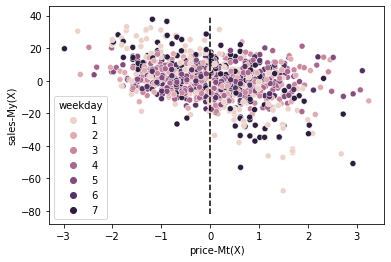

In [9]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles='--', color="black");

To summarize, by predicting the treatment, we've constructed \\(\hat{t}\\) which works as an unbiased version of the treatment; by predicting the outcome, we've contructed \\(\hat{y}\\) wich is a version of the outcome that is only explained by the treatment

Now that we have a version of the test wich is debiased, we can proceede like we did before with our elasticity model. First, we fit it on the training set.

In [10]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

Then, we make elasticity predictions on the debiased test set.

In [11]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
3547,24.9,1,1.0,8.8,200,1.789826,-22.640192,-13.782705
2021,29.6,3,1.0,6.8,210,0.826077,7.940743,-2.390025
8558,23.1,1,1.5,6.9,213,-0.616103,-5.945617,-13.891810
3995,19.0,1,0.5,6.1,236,-0.411450,23.631695,-10.864829
4444,29.4,3,1.5,7.1,215,0.621645,13.733196,-3.082770


Now, when it comes to ploting the cummulative elasticity, we still order the dataset by the predictive elasticity, but now we use the debiased versions of the treatment and outcome to get the elasticity. This is equivalent to estimating \\(\beta_1\\) in the folowing regression model

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

where the residuals have been made like we've described before.

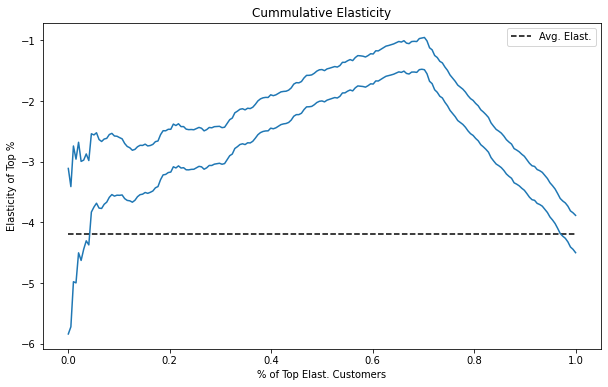

In [12]:
plt.figure(figsize=(10,6))

cumm_elast = cumulative_elast_curve_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_elast)))
plt.plot(x/x.max(), cumm_elast, color="C0")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cumulative Elasticity")
plt.legend();

We can do the same thing for the Qini curve, of course.

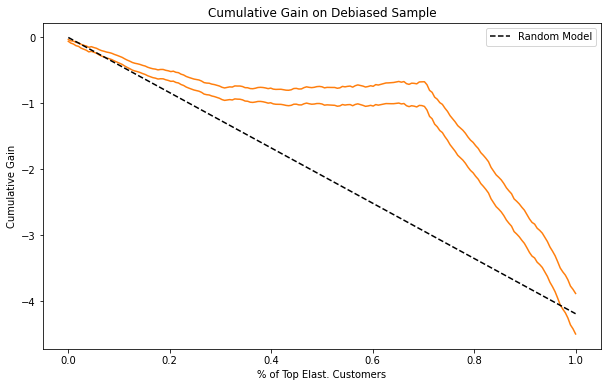

In [18]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain on Debiased Sample")
plt.legend();

And just to give you a sense of how inportant it is to debiase the set when computing the Qini curve, here is what it looks like if isetad use the biased sample. Notice that the price elasticity goes up, which is complete nonsense. As a result, a model that is good looks terrible.

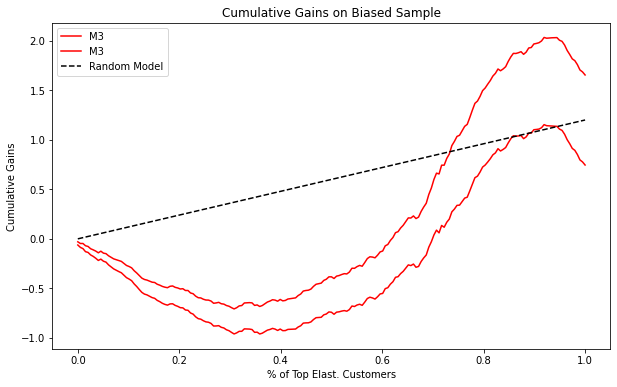

In [21]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M3", color="red")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.title("Cumulative Gains on Biased Sample")
plt.ylabel("Cumulative Gains")
plt.legend();